<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:09:09] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


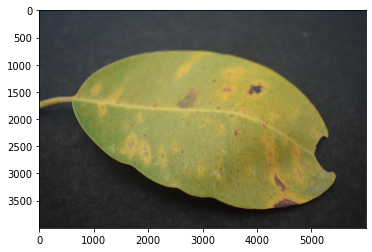

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

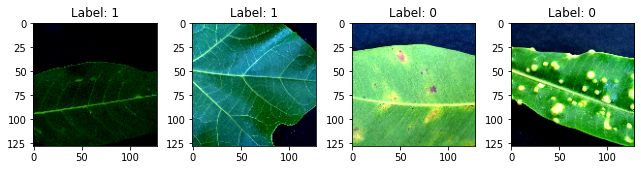

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:09:14] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:09:16] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2779532779532778 samples/sec                   batch loss = 0.9882780909538269 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2975899107167235 samples/sec                   batch loss = 0.6138322949409485 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2858716356862991 samples/sec                   batch loss = 0.517041027545929 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.2918545832604074 samples/sec                   batch loss = 0.8347426056861877 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.288296791746898 samples/sec                   batch loss = 0.9251301288604736 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2932537991587367 samples/sec                   batch loss = 0.5354036688804626 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.3005061498258055 samples/sec                   batch loss = 0.5352197289466858 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.29101577093549 samples/sec                   batch loss = 0.5812678933143616 | accuracy = 0.5375


Epoch[1] Batch[45] Speed: 1.2898940558307734 samples/sec                   batch loss = 0.7906451225280762 | accuracy = 0.5277777777777778


Epoch[1] Batch[50] Speed: 1.2850923470622304 samples/sec                   batch loss = 0.45396900177001953 | accuracy = 0.535


Epoch[1] Batch[55] Speed: 1.289254615709554 samples/sec                   batch loss = 0.7127028107643127 | accuracy = 0.5272727272727272


Epoch[1] Batch[60] Speed: 1.287468914897996 samples/sec                   batch loss = 0.7258908748626709 | accuracy = 0.5333333333333333


Epoch[1] Batch[65] Speed: 1.2928739956119757 samples/sec                   batch loss = 0.7056785225868225 | accuracy = 0.5346153846153846


Epoch[1] Batch[70] Speed: 1.2932828093345496 samples/sec                   batch loss = 0.6230522990226746 | accuracy = 0.5428571428571428


Epoch[1] Batch[75] Speed: 1.2856170219417984 samples/sec                   batch loss = 0.33359673619270325 | accuracy = 0.5633333333333334


Epoch[1] Batch[80] Speed: 1.2894325762718717 samples/sec                   batch loss = 0.8843329548835754 | accuracy = 0.56875


Epoch[1] Batch[85] Speed: 1.2875513187388683 samples/sec                   batch loss = 0.5579302310943604 | accuracy = 0.5735294117647058


Epoch[1] Batch[90] Speed: 1.297062539457577 samples/sec                   batch loss = 1.1455821990966797 | accuracy = 0.5805555555555556


Epoch[1] Batch[95] Speed: 1.2899138904953553 samples/sec                   batch loss = 0.5144311785697937 | accuracy = 0.5815789473684211


Epoch[1] Batch[100] Speed: 1.2955718300270562 samples/sec                   batch loss = 0.938944399356842 | accuracy = 0.59


Epoch[1] Batch[105] Speed: 1.2954057736658677 samples/sec                   batch loss = 1.6438605785369873 | accuracy = 0.5880952380952381


Epoch[1] Batch[110] Speed: 1.2907689474086705 samples/sec                   batch loss = 0.6024166941642761 | accuracy = 0.5886363636363636


Epoch[1] Batch[115] Speed: 1.287975559103322 samples/sec                   batch loss = 0.778842568397522 | accuracy = 0.5934782608695652


Epoch[1] Batch[120] Speed: 1.293543161626434 samples/sec                   batch loss = 0.3278241455554962 | accuracy = 0.5916666666666667


Epoch[1] Batch[125] Speed: 1.2906637905269713 samples/sec                   batch loss = 0.6998876929283142 | accuracy = 0.596


Epoch[1] Batch[130] Speed: 1.293550342493056 samples/sec                   batch loss = 0.7261372208595276 | accuracy = 0.5961538461538461


Epoch[1] Batch[135] Speed: 1.293074184368717 samples/sec                   batch loss = 1.033780574798584 | accuracy = 0.5925925925925926


Epoch[1] Batch[140] Speed: 1.2858535019608688 samples/sec                   batch loss = 0.2046303004026413 | accuracy = 0.5928571428571429


Epoch[1] Batch[145] Speed: 1.2864112494245459 samples/sec                   batch loss = 0.37339285016059875 | accuracy = 0.596551724137931


Epoch[1] Batch[150] Speed: 1.286508315535471 samples/sec                   batch loss = 0.40713125467300415 | accuracy = 0.6016666666666667


Epoch[1] Batch[155] Speed: 1.2874603194214154 samples/sec                   batch loss = 0.4976414740085602 | accuracy = 0.603225806451613


Epoch[1] Batch[160] Speed: 1.2924840596712108 samples/sec                   batch loss = 0.5393053293228149 | accuracy = 0.6046875


Epoch[1] Batch[165] Speed: 1.2937219091224688 samples/sec                   batch loss = 0.3873344659805298 | accuracy = 0.6075757575757575


Epoch[1] Batch[170] Speed: 1.291829715366077 samples/sec                   batch loss = 0.7968831658363342 | accuracy = 0.6073529411764705


Epoch[1] Batch[175] Speed: 1.2970856036098053 samples/sec                   batch loss = 0.5242597460746765 | accuracy = 0.61


Epoch[1] Batch[180] Speed: 1.293169168660248 samples/sec                   batch loss = 0.6191203594207764 | accuracy = 0.6152777777777778


Epoch[1] Batch[185] Speed: 1.2901456045565847 samples/sec                   batch loss = 0.2622895836830139 | accuracy = 0.6202702702702703


Epoch[1] Batch[190] Speed: 1.2979285089417203 samples/sec                   batch loss = 0.8489082455635071 | accuracy = 0.6157894736842106


Epoch[1] Batch[195] Speed: 1.293178039888907 samples/sec                   batch loss = 0.3244761824607849 | accuracy = 0.6192307692307693


Epoch[1] Batch[200] Speed: 1.290377302634691 samples/sec                   batch loss = 0.28681865334510803 | accuracy = 0.62375


Epoch[1] Batch[205] Speed: 1.288111430454011 samples/sec                   batch loss = 0.8987144231796265 | accuracy = 0.6268292682926829


Epoch[1] Batch[210] Speed: 1.2909178248318547 samples/sec                   batch loss = 0.39829370379447937 | accuracy = 0.6285714285714286


Epoch[1] Batch[215] Speed: 1.2936785144255596 samples/sec                   batch loss = 0.45417916774749756 | accuracy = 0.6325581395348837


Epoch[1] Batch[220] Speed: 1.290579002272273 samples/sec                   batch loss = 0.5197187066078186 | accuracy = 0.6352272727272728


Epoch[1] Batch[225] Speed: 1.2982912951451635 samples/sec                   batch loss = 0.7247246503829956 | accuracy = 0.6366666666666667


Epoch[1] Batch[230] Speed: 1.2932980626294477 samples/sec                   batch loss = 0.28602316975593567 | accuracy = 0.6391304347826087


Epoch[1] Batch[235] Speed: 1.2952105618402392 samples/sec                   batch loss = 1.1101983785629272 | accuracy = 0.6393617021276595


Epoch[1] Batch[240] Speed: 1.290645422102624 samples/sec                   batch loss = 0.48075684905052185 | accuracy = 0.6395833333333333


Epoch[1] Batch[245] Speed: 1.2965966187371836 samples/sec                   batch loss = 0.8161777257919312 | accuracy = 0.639795918367347


Epoch[1] Batch[250] Speed: 1.2947102003282998 samples/sec                   batch loss = 0.25862452387809753 | accuracy = 0.645


Epoch[1] Batch[255] Speed: 1.2971062617642242 samples/sec                   batch loss = 0.5868669748306274 | accuracy = 0.6450980392156863


Epoch[1] Batch[260] Speed: 1.2945772287900639 samples/sec                   batch loss = 0.2984077036380768 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.2999723768143454 samples/sec                   batch loss = 0.6759995818138123 | accuracy = 0.6509433962264151


Epoch[1] Batch[270] Speed: 1.2954190766128946 samples/sec                   batch loss = 0.9063510894775391 | accuracy = 0.6481481481481481


Epoch[1] Batch[275] Speed: 1.299912849547078 samples/sec                   batch loss = 0.9221469759941101 | accuracy = 0.6454545454545455


Epoch[1] Batch[280] Speed: 1.3012885049080214 samples/sec                   batch loss = 0.7128607630729675 | accuracy = 0.6446428571428572


Epoch[1] Batch[285] Speed: 1.2989145914843492 samples/sec                   batch loss = 0.4065573513507843 | accuracy = 0.6447368421052632


Epoch[1] Batch[290] Speed: 1.2996697609310837 samples/sec                   batch loss = 1.958264708518982 | accuracy = 0.6431034482758621


Epoch[1] Batch[295] Speed: 1.2934551027600112 samples/sec                   batch loss = 0.4771957993507385 | accuracy = 0.6432203389830509


Epoch[1] Batch[300] Speed: 1.2933559885496646 samples/sec                   batch loss = 0.45593953132629395 | accuracy = 0.6425


Epoch[1] Batch[305] Speed: 1.2917159320949743 samples/sec                   batch loss = 0.6778855919837952 | accuracy = 0.6418032786885246


Epoch[1] Batch[310] Speed: 1.2935359808395377 samples/sec                   batch loss = 0.8869504928588867 | accuracy = 0.6387096774193548


Epoch[1] Batch[315] Speed: 1.2966661648142956 samples/sec                   batch loss = 0.7162485122680664 | accuracy = 0.6365079365079365


Epoch[1] Batch[320] Speed: 1.2896948504578216 samples/sec                   batch loss = 0.47641098499298096 | accuracy = 0.6375


Epoch[1] Batch[325] Speed: 1.2603100591760426 samples/sec                   batch loss = 0.7659522294998169 | accuracy = 0.6384615384615384


Epoch[1] Batch[330] Speed: 1.2652397702944802 samples/sec                   batch loss = 0.3011877238750458 | accuracy = 0.6378787878787879


Epoch[1] Batch[335] Speed: 1.2631758378060038 samples/sec                   batch loss = 0.9958062767982483 | accuracy = 0.6373134328358209


Epoch[1] Batch[340] Speed: 1.235172688936398 samples/sec                   batch loss = 0.5780080556869507 | accuracy = 0.6389705882352941


Epoch[1] Batch[345] Speed: 1.2578870723308369 samples/sec                   batch loss = 0.27184391021728516 | accuracy = 0.6398550724637682


Epoch[1] Batch[350] Speed: 1.2585544895992242 samples/sec                   batch loss = 0.44066470861434937 | accuracy = 0.6428571428571429


Epoch[1] Batch[355] Speed: 1.2657672644825766 samples/sec                   batch loss = 0.5012226700782776 | accuracy = 0.643661971830986


Epoch[1] Batch[360] Speed: 1.2632721874898585 samples/sec                   batch loss = 0.7290205955505371 | accuracy = 0.6430555555555556


Epoch[1] Batch[365] Speed: 1.2597591028005608 samples/sec                   batch loss = 0.6901885867118835 | accuracy = 0.6424657534246575


Epoch[1] Batch[370] Speed: 1.2620890468074268 samples/sec                   batch loss = 0.3573026657104492 | accuracy = 0.6405405405405405


Epoch[1] Batch[375] Speed: 1.2682515083396082 samples/sec                   batch loss = 0.5980038642883301 | accuracy = 0.6406666666666667


Epoch[1] Batch[380] Speed: 1.2675423578991267 samples/sec                   batch loss = 1.2245416641235352 | accuracy = 0.6414473684210527


Epoch[1] Batch[385] Speed: 1.2654327328997563 samples/sec                   batch loss = 0.5438059568405151 | accuracy = 0.6415584415584416


Epoch[1] Batch[390] Speed: 1.26964817114973 samples/sec                   batch loss = 0.43759265542030334 | accuracy = 0.6435897435897436


Epoch[1] Batch[395] Speed: 1.2657278256234725 samples/sec                   batch loss = 0.3869655728340149 | accuracy = 0.6443037974683544


Epoch[1] Batch[400] Speed: 1.2705175491905543 samples/sec                   batch loss = 0.583166778087616 | accuracy = 0.644375


Epoch[1] Batch[405] Speed: 1.261613185218328 samples/sec                   batch loss = 0.6560656428337097 | accuracy = 0.6438271604938272


Epoch[1] Batch[410] Speed: 1.2612275584709431 samples/sec                   batch loss = 0.45861563086509705 | accuracy = 0.6475609756097561


Epoch[1] Batch[415] Speed: 1.2582432923866425 samples/sec                   batch loss = 0.9498180747032166 | accuracy = 0.6463855421686747


Epoch[1] Batch[420] Speed: 1.2589407504802104 samples/sec                   batch loss = 0.407405287027359 | accuracy = 0.6470238095238096


Epoch[1] Batch[425] Speed: 1.2562098173588636 samples/sec                   batch loss = 0.576202392578125 | accuracy = 0.6464705882352941


Epoch[1] Batch[430] Speed: 1.2613220939255985 samples/sec                   batch loss = 1.0309181213378906 | accuracy = 0.6459302325581395


Epoch[1] Batch[435] Speed: 1.2608927685269824 samples/sec                   batch loss = 0.9960858821868896 | accuracy = 0.6459770114942529


Epoch[1] Batch[440] Speed: 1.26318734573174 samples/sec                   batch loss = 0.43347546458244324 | accuracy = 0.6454545454545455


Epoch[1] Batch[445] Speed: 1.2629707275655075 samples/sec                   batch loss = 0.39367738366127014 | accuracy = 0.6466292134831461


Epoch[1] Batch[450] Speed: 1.2574450023856445 samples/sec                   batch loss = 0.2726179361343384 | accuracy = 0.6488888888888888


Epoch[1] Batch[455] Speed: 1.2567255712832952 samples/sec                   batch loss = 0.44065067172050476 | accuracy = 0.6494505494505495


Epoch[1] Batch[460] Speed: 1.2628197663937706 samples/sec                   batch loss = 0.3396230638027191 | accuracy = 0.6489130434782608


Epoch[1] Batch[465] Speed: 1.2635217377617254 samples/sec                   batch loss = 0.6186600923538208 | accuracy = 0.6505376344086021


Epoch[1] Batch[470] Speed: 1.2592411400350139 samples/sec                   batch loss = 0.41891828179359436 | accuracy = 0.6510638297872341


Epoch[1] Batch[475] Speed: 1.2654194660295779 samples/sec                   batch loss = 0.6167173385620117 | accuracy = 0.6521052631578947


Epoch[1] Batch[480] Speed: 1.2710411728853597 samples/sec                   batch loss = 0.4729594886302948 | accuracy = 0.653125


Epoch[1] Batch[485] Speed: 1.2772153485857745 samples/sec                   batch loss = 0.6387618184089661 | accuracy = 0.6530927835051547


Epoch[1] Batch[490] Speed: 1.273958533134265 samples/sec                   batch loss = 0.6868991851806641 | accuracy = 0.6540816326530612


Epoch[1] Batch[495] Speed: 1.2692563692366539 samples/sec                   batch loss = 0.8344116806983948 | accuracy = 0.6540404040404041


Epoch[1] Batch[500] Speed: 1.2672311993032848 samples/sec                   batch loss = 0.7558680176734924 | accuracy = 0.654


Epoch[1] Batch[505] Speed: 1.261430869899408 samples/sec                   batch loss = 0.38434529304504395 | accuracy = 0.655940594059406


Epoch[1] Batch[510] Speed: 1.267164296230603 samples/sec                   batch loss = 1.4414489269256592 | accuracy = 0.6549019607843137


Epoch[1] Batch[515] Speed: 1.2583677716789066 samples/sec                   batch loss = 0.6707282066345215 | accuracy = 0.654368932038835


Epoch[1] Batch[520] Speed: 1.2599719711101616 samples/sec                   batch loss = 0.6603193879127502 | accuracy = 0.6543269230769231


Epoch[1] Batch[525] Speed: 1.2539557733093603 samples/sec                   batch loss = 0.6311174631118774 | accuracy = 0.6542857142857142


Epoch[1] Batch[530] Speed: 1.2469346182706382 samples/sec                   batch loss = 0.6740264296531677 | accuracy = 0.6556603773584906


Epoch[1] Batch[535] Speed: 1.2527522187026172 samples/sec                   batch loss = 0.8703919649124146 | accuracy = 0.6546728971962616


Epoch[1] Batch[540] Speed: 1.2517771395324442 samples/sec                   batch loss = 1.274116039276123 | accuracy = 0.6555555555555556


Epoch[1] Batch[545] Speed: 1.2575894022340832 samples/sec                   batch loss = 0.6174041032791138 | accuracy = 0.655045871559633


Epoch[1] Batch[550] Speed: 1.2581096862250198 samples/sec                   batch loss = 0.13170480728149414 | accuracy = 0.6568181818181819


Epoch[1] Batch[555] Speed: 1.2580578931637127 samples/sec                   batch loss = 0.7376034259796143 | accuracy = 0.6581081081081082


Epoch[1] Batch[560] Speed: 1.262630450503484 samples/sec                   batch loss = 0.19862103462219238 | accuracy = 0.6602678571428572


Epoch[1] Batch[565] Speed: 1.2663090574010196 samples/sec                   batch loss = 0.40178075432777405 | accuracy = 0.6606194690265487


Epoch[1] Batch[570] Speed: 1.2602694449477345 samples/sec                   batch loss = 0.42812490463256836 | accuracy = 0.6622807017543859


Epoch[1] Batch[575] Speed: 1.2587987791377178 samples/sec                   batch loss = 0.7677188515663147 | accuracy = 0.6621739130434783


Epoch[1] Batch[580] Speed: 1.2611165424458686 samples/sec                   batch loss = 0.8862690329551697 | accuracy = 0.6629310344827586


Epoch[1] Batch[585] Speed: 1.2580502519255 samples/sec                   batch loss = 0.3230217695236206 | accuracy = 0.6632478632478632


Epoch[1] Batch[590] Speed: 1.2641494264608981 samples/sec                   batch loss = 0.6940310597419739 | accuracy = 0.6635593220338983


Epoch[1] Batch[595] Speed: 1.26189491951114 samples/sec                   batch loss = 0.2689400613307953 | accuracy = 0.6647058823529411


Epoch[1] Batch[600] Speed: 1.2629688260668832 samples/sec                   batch loss = 0.4820701479911804 | accuracy = 0.6658333333333334


Epoch[1] Batch[605] Speed: 1.2618747033293825 samples/sec                   batch loss = 0.23399797081947327 | accuracy = 0.6677685950413224


Epoch[1] Batch[610] Speed: 1.2642903207866487 samples/sec                   batch loss = 1.0534619092941284 | accuracy = 0.6680327868852459


Epoch[1] Batch[615] Speed: 1.2601034177302086 samples/sec                   batch loss = 0.934744656085968 | accuracy = 0.6686991869918699


Epoch[1] Batch[620] Speed: 1.2664906823131648 samples/sec                   batch loss = 0.861342191696167 | accuracy = 0.6681451612903225


Epoch[1] Batch[625] Speed: 1.2689746020011525 samples/sec                   batch loss = 0.32115885615348816 | accuracy = 0.6696


Epoch[1] Batch[630] Speed: 1.2646503679099987 samples/sec                   batch loss = 0.29522809386253357 | accuracy = 0.671031746031746


Epoch[1] Batch[635] Speed: 1.258910237636602 samples/sec                   batch loss = 0.5754299163818359 | accuracy = 0.6716535433070866


Epoch[1] Batch[640] Speed: 1.259325452511011 samples/sec                   batch loss = 0.7348862290382385 | accuracy = 0.671484375


Epoch[1] Batch[645] Speed: 1.2583613536454656 samples/sec                   batch loss = 0.7499515414237976 | accuracy = 0.6705426356589147


Epoch[1] Batch[650] Speed: 1.258249520484634 samples/sec                   batch loss = 0.6664900779724121 | accuracy = 0.6703846153846154


Epoch[1] Batch[655] Speed: 1.26540543590118 samples/sec                   batch loss = 0.24063818156719208 | accuracy = 0.6717557251908397


Epoch[1] Batch[660] Speed: 1.2604466898843714 samples/sec                   batch loss = 0.45903530716896057 | accuracy = 0.6727272727272727


Epoch[1] Batch[665] Speed: 1.2614212907909688 samples/sec                   batch loss = 0.4745888411998749 | accuracy = 0.6729323308270677


Epoch[1] Batch[670] Speed: 1.2641144697161946 samples/sec                   batch loss = 0.6040711402893066 | accuracy = 0.6720149253731343


Epoch[1] Batch[675] Speed: 1.2645557141663013 samples/sec                   batch loss = 0.9163604378700256 | accuracy = 0.6714814814814815


Epoch[1] Batch[680] Speed: 1.260108717809132 samples/sec                   batch loss = 0.48601624369621277 | accuracy = 0.6709558823529411


Epoch[1] Batch[685] Speed: 1.264261072390354 samples/sec                   batch loss = 0.5683610439300537 | accuracy = 0.6708029197080292


Epoch[1] Batch[690] Speed: 1.2687961981223541 samples/sec                   batch loss = 0.9527875781059265 | accuracy = 0.6713768115942029


Epoch[1] Batch[695] Speed: 1.2616804521987415 samples/sec                   batch loss = 0.6064116358757019 | accuracy = 0.6719424460431654


Epoch[1] Batch[700] Speed: 1.262773382552034 samples/sec                   batch loss = 0.5019533634185791 | accuracy = 0.6714285714285714


Epoch[1] Batch[705] Speed: 1.2656377843650144 samples/sec                   batch loss = 0.25628477334976196 | accuracy = 0.6719858156028369


Epoch[1] Batch[710] Speed: 1.263651927388966 samples/sec                   batch loss = 0.4758549928665161 | accuracy = 0.6714788732394367


Epoch[1] Batch[715] Speed: 1.2668147731791197 samples/sec                   batch loss = 0.4317573010921478 | accuracy = 0.6723776223776223


Epoch[1] Batch[720] Speed: 1.2626920289612378 samples/sec                   batch loss = 0.6021134257316589 | accuracy = 0.6729166666666667


Epoch[1] Batch[725] Speed: 1.2609305798898254 samples/sec                   batch loss = 0.7848478555679321 | accuracy = 0.6727586206896552


Epoch[1] Batch[730] Speed: 1.2639808518068019 samples/sec                   batch loss = 0.8902583122253418 | accuracy = 0.6726027397260274


Epoch[1] Batch[735] Speed: 1.2664581771857635 samples/sec                   batch loss = 0.44179368019104004 | accuracy = 0.6741496598639456


Epoch[1] Batch[740] Speed: 1.2735891065921983 samples/sec                   batch loss = 0.5111310482025146 | accuracy = 0.6746621621621621


Epoch[1] Batch[745] Speed: 1.2602177578973857 samples/sec                   batch loss = 0.631934404373169 | accuracy = 0.6758389261744966


Epoch[1] Batch[750] Speed: 1.255590456318221 samples/sec                   batch loss = 0.26025140285491943 | accuracy = 0.6763333333333333


Epoch[1] Batch[755] Speed: 1.2613936923909626 samples/sec                   batch loss = 0.4699368178844452 | accuracy = 0.6778145695364238


Epoch[1] Batch[760] Speed: 1.2605304062135978 samples/sec                   batch loss = 0.49134981632232666 | accuracy = 0.6789473684210526


Epoch[1] Batch[765] Speed: 1.2600630060944447 samples/sec                   batch loss = 0.6252157092094421 | accuracy = 0.6790849673202615


Epoch[1] Batch[770] Speed: 1.2591543818075885 samples/sec                   batch loss = 0.24951352179050446 | accuracy = 0.6798701298701298


Epoch[1] Batch[775] Speed: 1.2618425296153495 samples/sec                   batch loss = 0.7150031328201294 | accuracy = 0.6790322580645162


Epoch[1] Batch[780] Speed: 1.2611115182716748 samples/sec                   batch loss = 0.4033927619457245 | accuracy = 0.6801282051282052


Epoch[1] Batch[785] Speed: 1.2618368353235758 samples/sec                   batch loss = 0.3708387017250061 | accuracy = 0.6812101910828026


[Epoch 1] training: accuracy=0.6811548223350253
[Epoch 1] time cost: 645.5805263519287
[Epoch 1] validation: validation accuracy=0.7266666666666667


Epoch[2] Batch[5] Speed: 1.268899837087974 samples/sec                   batch loss = 0.7570915818214417 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2661435373362635 samples/sec                   batch loss = 0.3847265839576721 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2683902500096014 samples/sec                   batch loss = 0.4247211217880249 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2656111468302005 samples/sec                   batch loss = 0.5836250185966492 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2605512423223597 samples/sec                   batch loss = 0.7336326837539673 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2626729275933344 samples/sec                   batch loss = 0.9446678161621094 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.2669206717908192 samples/sec                   batch loss = 0.7262464761734009 | accuracy = 0.6857142857142857


Epoch[2] Batch[40] Speed: 1.2603101538509616 samples/sec                   batch loss = 0.69101482629776 | accuracy = 0.69375


Epoch[2] Batch[45] Speed: 1.257997709134459 samples/sec                   batch loss = 0.6957959532737732 | accuracy = 0.6833333333333333


Epoch[2] Batch[50] Speed: 1.2582612219263876 samples/sec                   batch loss = 0.5371220111846924 | accuracy = 0.675


Epoch[2] Batch[55] Speed: 1.2631487331896358 samples/sec                   batch loss = 0.4969494342803955 | accuracy = 0.6772727272727272


Epoch[2] Batch[60] Speed: 1.2648933106348585 samples/sec                   batch loss = 0.561363697052002 | accuracy = 0.675


Epoch[2] Batch[65] Speed: 1.2612075532858404 samples/sec                   batch loss = 0.19492672383785248 | accuracy = 0.6807692307692308


Epoch[2] Batch[70] Speed: 1.257665479982072 samples/sec                   batch loss = 0.5638054013252258 | accuracy = 0.6964285714285714


Epoch[2] Batch[75] Speed: 1.277036467115764 samples/sec                   batch loss = 0.7286326289176941 | accuracy = 0.69


Epoch[2] Batch[80] Speed: 1.2678816469598513 samples/sec                   batch loss = 0.5116121768951416 | accuracy = 0.696875


Epoch[2] Batch[85] Speed: 1.2746796285158657 samples/sec                   batch loss = 0.3574889600276947 | accuracy = 0.6970588235294117


Epoch[2] Batch[90] Speed: 1.2709754074689998 samples/sec                   batch loss = 0.5063828229904175 | accuracy = 0.7055555555555556


Epoch[2] Batch[95] Speed: 1.2719857483629564 samples/sec                   batch loss = 0.26523131132125854 | accuracy = 0.7105263157894737


Epoch[2] Batch[100] Speed: 1.2718249114521216 samples/sec                   batch loss = 0.5731914043426514 | accuracy = 0.7125


Epoch[2] Batch[105] Speed: 1.2769245944520826 samples/sec                   batch loss = 0.28301170468330383 | accuracy = 0.719047619047619


Epoch[2] Batch[110] Speed: 1.2627475307420535 samples/sec                   batch loss = 0.33290591835975647 | accuracy = 0.7204545454545455


Epoch[2] Batch[115] Speed: 1.2563873334542501 samples/sec                   batch loss = 0.3518652617931366 | accuracy = 0.7260869565217392


Epoch[2] Batch[120] Speed: 1.257842276091663 samples/sec                   batch loss = 0.35572439432144165 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.262249424858944 samples/sec                   batch loss = 0.46602630615234375 | accuracy = 0.726


Epoch[2] Batch[130] Speed: 1.2623017535739112 samples/sec                   batch loss = 0.1655377596616745 | accuracy = 0.7326923076923076


Epoch[2] Batch[135] Speed: 1.261123178208986 samples/sec                   batch loss = 0.5220722556114197 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.2611934267838794 samples/sec                   batch loss = 0.8530904650688171 | accuracy = 0.7267857142857143


Epoch[2] Batch[145] Speed: 1.2597758458343158 samples/sec                   batch loss = 0.5987384915351868 | accuracy = 0.7241379310344828


Epoch[2] Batch[150] Speed: 1.270143191905892 samples/sec                   batch loss = 0.4408361613750458 | accuracy = 0.7216666666666667


Epoch[2] Batch[155] Speed: 1.2635486680642318 samples/sec                   batch loss = 0.7970888018608093 | accuracy = 0.7193548387096774


Epoch[2] Batch[160] Speed: 1.267638321307912 samples/sec                   batch loss = 0.7630066871643066 | accuracy = 0.71875


Epoch[2] Batch[165] Speed: 1.249602619268033 samples/sec                   batch loss = 0.657909095287323 | accuracy = 0.7166666666666667


Epoch[2] Batch[170] Speed: 1.2529793818575223 samples/sec                   batch loss = 0.8282932043075562 | accuracy = 0.7132352941176471


Epoch[2] Batch[175] Speed: 1.2578964092119689 samples/sec                   batch loss = 0.3730161786079407 | accuracy = 0.7114285714285714


Epoch[2] Batch[180] Speed: 1.2613587930507295 samples/sec                   batch loss = 0.7324409484863281 | accuracy = 0.7097222222222223


Epoch[2] Batch[185] Speed: 1.2549042135276887 samples/sec                   batch loss = 0.49813854694366455 | accuracy = 0.7108108108108108


Epoch[2] Batch[190] Speed: 1.2556627212256584 samples/sec                   batch loss = 0.7503325939178467 | accuracy = 0.7131578947368421


Epoch[2] Batch[195] Speed: 1.257134541936328 samples/sec                   batch loss = 0.4723350405693054 | accuracy = 0.7128205128205128


Epoch[2] Batch[200] Speed: 1.262059425481116 samples/sec                   batch loss = 0.4118552505970001 | accuracy = 0.71125


Epoch[2] Batch[205] Speed: 1.2657705113746618 samples/sec                   batch loss = 0.2416464388370514 | accuracy = 0.7134146341463414


Epoch[2] Batch[210] Speed: 1.2675534666918105 samples/sec                   batch loss = 0.3812740445137024 | accuracy = 0.7154761904761905


Epoch[2] Batch[215] Speed: 1.257001547836958 samples/sec                   batch loss = 0.6950720548629761 | accuracy = 0.7151162790697675


Epoch[2] Batch[220] Speed: 1.2621660497728024 samples/sec                   batch loss = 0.9109524488449097 | accuracy = 0.7113636363636363


Epoch[2] Batch[225] Speed: 1.2613443786693976 samples/sec                   batch loss = 0.6898069381713867 | accuracy = 0.7122222222222222


Epoch[2] Batch[230] Speed: 1.2617301717561384 samples/sec                   batch loss = 0.9520816206932068 | accuracy = 0.7130434782608696


Epoch[2] Batch[235] Speed: 1.261987656494948 samples/sec                   batch loss = 0.4837600290775299 | accuracy = 0.7148936170212766


Epoch[2] Batch[240] Speed: 1.2664364761619067 samples/sec                   batch loss = 0.5253468751907349 | accuracy = 0.7125


Epoch[2] Batch[245] Speed: 1.2641258042526733 samples/sec                   batch loss = 0.6400463581085205 | accuracy = 0.710204081632653


Epoch[2] Batch[250] Speed: 1.265201127588352 samples/sec                   batch loss = 0.3474021852016449 | accuracy = 0.712


Epoch[2] Batch[255] Speed: 1.2692761504440178 samples/sec                   batch loss = 0.4516586363315582 | accuracy = 0.7137254901960784


Epoch[2] Batch[260] Speed: 1.261855721588737 samples/sec                   batch loss = 0.43491503596305847 | accuracy = 0.7144230769230769


Epoch[2] Batch[265] Speed: 1.2639319069124666 samples/sec                   batch loss = 0.4702564775943756 | accuracy = 0.7150943396226415


Epoch[2] Batch[270] Speed: 1.2639923744051356 samples/sec                   batch loss = 0.9142767786979675 | accuracy = 0.7148148148148148


Epoch[2] Batch[275] Speed: 1.262270507775763 samples/sec                   batch loss = 0.4053075611591339 | accuracy = 0.7145454545454546


Epoch[2] Batch[280] Speed: 1.265385584278256 samples/sec                   batch loss = 0.2917867600917816 | accuracy = 0.7151785714285714


Epoch[2] Batch[285] Speed: 1.2652115274919227 samples/sec                   batch loss = 0.28635671734809875 | accuracy = 0.7166666666666667


Epoch[2] Batch[290] Speed: 1.256404175159224 samples/sec                   batch loss = 0.7475625276565552 | accuracy = 0.7146551724137931


Epoch[2] Batch[295] Speed: 1.2541816855799446 samples/sec                   batch loss = 0.2557181715965271 | accuracy = 0.7169491525423729


Epoch[2] Batch[300] Speed: 1.2591146924867536 samples/sec                   batch loss = 0.5723279714584351 | accuracy = 0.7166666666666667


Epoch[2] Batch[305] Speed: 1.25618912452375 samples/sec                   batch loss = 0.680234432220459 | accuracy = 0.7180327868852459


Epoch[2] Batch[310] Speed: 1.2675460927301119 samples/sec                   batch loss = 0.47881579399108887 | accuracy = 0.717741935483871


Epoch[2] Batch[315] Speed: 1.2623043178874278 samples/sec                   batch loss = 0.4286837875843048 | accuracy = 0.719047619047619


Epoch[2] Batch[320] Speed: 1.265422424803861 samples/sec                   batch loss = 0.4213904142379761 | accuracy = 0.72109375


Epoch[2] Batch[325] Speed: 1.2598374299737425 samples/sec                   batch loss = 0.35800522565841675 | accuracy = 0.72


Epoch[2] Batch[330] Speed: 1.2581973384785494 samples/sec                   batch loss = 0.6947609186172485 | accuracy = 0.7219696969696969


Epoch[2] Batch[335] Speed: 1.2592154326471772 samples/sec                   batch loss = 0.5510236024856567 | accuracy = 0.7208955223880597


Epoch[2] Batch[340] Speed: 1.2639477136039992 samples/sec                   batch loss = 0.6647984981536865 | accuracy = 0.7205882352941176


Epoch[2] Batch[345] Speed: 1.2594061837796546 samples/sec                   batch loss = 0.1331411451101303 | accuracy = 0.7210144927536232


Epoch[2] Batch[350] Speed: 1.25883995980948 samples/sec                   batch loss = 0.4292946755886078 | accuracy = 0.7221428571428572


Epoch[2] Batch[355] Speed: 1.256269454160683 samples/sec                   batch loss = 0.53000807762146 | accuracy = 0.7211267605633803


Epoch[2] Batch[360] Speed: 1.2582341390817926 samples/sec                   batch loss = 0.5282079577445984 | accuracy = 0.7222222222222222


Epoch[2] Batch[365] Speed: 1.25885970104099 samples/sec                   batch loss = 0.4541064202785492 | accuracy = 0.7226027397260274


Epoch[2] Batch[370] Speed: 1.2579858239412383 samples/sec                   batch loss = 0.4326934814453125 | accuracy = 0.7243243243243244


Epoch[2] Batch[375] Speed: 1.2696186743314515 samples/sec                   batch loss = 0.27150240540504456 | accuracy = 0.7266666666666667


Epoch[2] Batch[380] Speed: 1.2716725010596504 samples/sec                   batch loss = 0.131797194480896 | accuracy = 0.7276315789473684


Epoch[2] Batch[385] Speed: 1.2657793926645795 samples/sec                   batch loss = 1.0713855028152466 | accuracy = 0.7259740259740259


Epoch[2] Batch[390] Speed: 1.272431733858368 samples/sec                   batch loss = 0.4935251474380493 | accuracy = 0.7237179487179487


Epoch[2] Batch[395] Speed: 1.268743713363956 samples/sec                   batch loss = 0.40321922302246094 | accuracy = 0.7227848101265822


Epoch[2] Batch[400] Speed: 1.2669389451579647 samples/sec                   batch loss = 0.8955247402191162 | accuracy = 0.721875


Epoch[2] Batch[405] Speed: 1.2677298927570386 samples/sec                   batch loss = 0.19866976141929626 | accuracy = 0.7234567901234568


Epoch[2] Batch[410] Speed: 1.267757194336885 samples/sec                   batch loss = 0.42517876625061035 | accuracy = 0.725


Epoch[2] Batch[415] Speed: 1.2576985724326697 samples/sec                   batch loss = 0.13478676974773407 | accuracy = 0.7259036144578314


Epoch[2] Batch[420] Speed: 1.262203842581426 samples/sec                   batch loss = 0.4018411338329315 | accuracy = 0.7267857142857143


Epoch[2] Batch[425] Speed: 1.2636001528622431 samples/sec                   batch loss = 0.3762822449207306 | accuracy = 0.7270588235294118


Epoch[2] Batch[430] Speed: 1.2627343201154744 samples/sec                   batch loss = 0.5975500345230103 | accuracy = 0.7290697674418605


Epoch[2] Batch[435] Speed: 1.2644645053849652 samples/sec                   batch loss = 0.6214308738708496 | accuracy = 0.7304597701149426


Epoch[2] Batch[440] Speed: 1.257589590767311 samples/sec                   batch loss = 0.3028257191181183 | accuracy = 0.7323863636363637


Epoch[2] Batch[445] Speed: 1.2576682140501703 samples/sec                   batch loss = 0.7858908772468567 | accuracy = 0.7297752808988764


Epoch[2] Batch[450] Speed: 1.2633133759949302 samples/sec                   batch loss = 0.5524290800094604 | accuracy = 0.73


Epoch[2] Batch[455] Speed: 1.2571863532031462 samples/sec                   batch loss = 0.5475379824638367 | accuracy = 0.7274725274725274


Epoch[2] Batch[460] Speed: 1.2651324352720446 samples/sec                   batch loss = 0.5786735415458679 | accuracy = 0.7277173913043479


Epoch[2] Batch[465] Speed: 1.2564059628527395 samples/sec                   batch loss = 0.10653463751077652 | accuracy = 0.7290322580645161


Epoch[2] Batch[470] Speed: 1.2570554202427449 samples/sec                   batch loss = 0.51511150598526 | accuracy = 0.7297872340425532


Epoch[2] Batch[475] Speed: 1.261667548526612 samples/sec                   batch loss = 0.2806965708732605 | accuracy = 0.73


Epoch[2] Batch[480] Speed: 1.2587220920401576 samples/sec                   batch loss = 0.5836529731750488 | accuracy = 0.7291666666666666


Epoch[2] Batch[485] Speed: 1.255160046369326 samples/sec                   batch loss = 0.5102865695953369 | accuracy = 0.729381443298969


Epoch[2] Batch[490] Speed: 1.257422666728524 samples/sec                   batch loss = 0.8760236501693726 | accuracy = 0.7290816326530613


Epoch[2] Batch[495] Speed: 1.2584847234883545 samples/sec                   batch loss = 0.2893412113189697 | accuracy = 0.7287878787878788


Epoch[2] Batch[500] Speed: 1.2612330576377666 samples/sec                   batch loss = 0.5834274888038635 | accuracy = 0.7285


Epoch[2] Batch[505] Speed: 1.2587789453718579 samples/sec                   batch loss = 0.25940844416618347 | accuracy = 0.7282178217821782


Epoch[2] Batch[510] Speed: 1.2627393572282561 samples/sec                   batch loss = 0.45989206433296204 | accuracy = 0.7299019607843137


Epoch[2] Batch[515] Speed: 1.2644957645929162 samples/sec                   batch loss = 0.060863249003887177 | accuracy = 0.7305825242718447


Epoch[2] Batch[520] Speed: 1.2635222135521613 samples/sec                   batch loss = 0.5351877808570862 | accuracy = 0.7307692307692307


Epoch[2] Batch[525] Speed: 1.26018538465167 samples/sec                   batch loss = 0.26305249333381653 | accuracy = 0.731904761904762


Epoch[2] Batch[530] Speed: 1.266970135473514 samples/sec                   batch loss = 0.47326555848121643 | accuracy = 0.7330188679245283


Epoch[2] Batch[535] Speed: 1.271245156362202 samples/sec                   batch loss = 0.15140454471111298 | accuracy = 0.7345794392523365


Epoch[2] Batch[540] Speed: 1.2725702333748619 samples/sec                   batch loss = 0.557316243648529 | accuracy = 0.7351851851851852


Epoch[2] Batch[545] Speed: 1.2677057533922802 samples/sec                   batch loss = 0.3491016924381256 | accuracy = 0.736697247706422


Epoch[2] Batch[550] Speed: 1.257388081010814 samples/sec                   batch loss = 0.7608602046966553 | accuracy = 0.7368181818181818


Epoch[2] Batch[555] Speed: 1.2604294555498676 samples/sec                   batch loss = 0.47693634033203125 | accuracy = 0.7378378378378379


Epoch[2] Batch[560] Speed: 1.2601434533585054 samples/sec                   batch loss = 0.3618118464946747 | accuracy = 0.7379464285714286


Epoch[2] Batch[565] Speed: 1.2655785913658735 samples/sec                   batch loss = 0.5440077781677246 | accuracy = 0.7393805309734514


Epoch[2] Batch[570] Speed: 1.2662022098215786 samples/sec                   batch loss = 0.5518032908439636 | accuracy = 0.7394736842105263


Epoch[2] Batch[575] Speed: 1.268277777756779 samples/sec                   batch loss = 0.7294001579284668 | accuracy = 0.7386956521739131


Epoch[2] Batch[580] Speed: 1.2688246011917133 samples/sec                   batch loss = 0.36892572045326233 | accuracy = 0.7387931034482759


Epoch[2] Batch[585] Speed: 1.2640394192590807 samples/sec                   batch loss = 0.4514729380607605 | accuracy = 0.7384615384615385


Epoch[2] Batch[590] Speed: 1.259860892182092 samples/sec                   batch loss = 0.8379032015800476 | accuracy = 0.7389830508474576


Epoch[2] Batch[595] Speed: 1.258593105021067 samples/sec                   batch loss = 1.0325311422348022 | accuracy = 0.7394957983193278


Epoch[2] Batch[600] Speed: 1.263439716846148 samples/sec                   batch loss = 0.25167927145957947 | accuracy = 0.7404166666666666


Epoch[2] Batch[605] Speed: 1.262364724730232 samples/sec                   batch loss = 0.6182044148445129 | accuracy = 0.7413223140495868


Epoch[2] Batch[610] Speed: 1.259083131812832 samples/sec                   batch loss = 0.3468317687511444 | accuracy = 0.7397540983606558


Epoch[2] Batch[615] Speed: 1.2620386344191123 samples/sec                   batch loss = 0.12458476424217224 | accuracy = 0.7414634146341463


Epoch[2] Batch[620] Speed: 1.2643738814783632 samples/sec                   batch loss = 0.8486427068710327 | accuracy = 0.7419354838709677


Epoch[2] Batch[625] Speed: 1.2645393203955575 samples/sec                   batch loss = 0.7043437957763672 | accuracy = 0.7416


Epoch[2] Batch[630] Speed: 1.2624448012015532 samples/sec                   batch loss = 0.3694407343864441 | accuracy = 0.7416666666666667


Epoch[2] Batch[635] Speed: 1.260468564910741 samples/sec                   batch loss = 0.2990884780883789 | accuracy = 0.7413385826771653


Epoch[2] Batch[640] Speed: 1.2598927756964653 samples/sec                   batch loss = 0.323966383934021 | accuracy = 0.741796875


Epoch[2] Batch[645] Speed: 1.2641676199730638 samples/sec                   batch loss = 0.44270268082618713 | accuracy = 0.7434108527131783


Epoch[2] Batch[650] Speed: 1.2716930323989133 samples/sec                   batch loss = 0.4297421872615814 | accuracy = 0.7434615384615385


Epoch[2] Batch[655] Speed: 1.2640154202320628 samples/sec                   batch loss = 0.21024806797504425 | accuracy = 0.7438931297709923


Epoch[2] Batch[660] Speed: 1.2649843905333609 samples/sec                   batch loss = 0.31643185019493103 | accuracy = 0.7443181818181818


Epoch[2] Batch[665] Speed: 1.266977311376905 samples/sec                   batch loss = 0.17110581696033478 | accuracy = 0.7458646616541353


Epoch[2] Batch[670] Speed: 1.2605131695896943 samples/sec                   batch loss = 0.4210490584373474 | accuracy = 0.7470149253731343


Epoch[2] Batch[675] Speed: 1.2530501298742813 samples/sec                   batch loss = 0.7235376834869385 | accuracy = 0.7481481481481481


Epoch[2] Batch[680] Speed: 1.2630040997983978 samples/sec                   batch loss = 0.5765597820281982 | accuracy = 0.7485294117647059


Epoch[2] Batch[685] Speed: 1.2689880395049036 samples/sec                   batch loss = 0.81951904296875 | accuracy = 0.7485401459854014


Epoch[2] Batch[690] Speed: 1.2619996174257961 samples/sec                   batch loss = 0.6396281123161316 | accuracy = 0.7485507246376811


Epoch[2] Batch[695] Speed: 1.2635917779698167 samples/sec                   batch loss = 0.7568860054016113 | accuracy = 0.7478417266187051


Epoch[2] Batch[700] Speed: 1.2583337002207249 samples/sec                   batch loss = 0.2921881079673767 | accuracy = 0.7489285714285714


Epoch[2] Batch[705] Speed: 1.2516957024200233 samples/sec                   batch loss = 0.35242852568626404 | accuracy = 0.749645390070922


Epoch[2] Batch[710] Speed: 1.2624447062056519 samples/sec                   batch loss = 0.45276471972465515 | accuracy = 0.7485915492957746


Epoch[2] Batch[715] Speed: 1.2648498258017298 samples/sec                   batch loss = 0.3548600673675537 | accuracy = 0.7486013986013986


Epoch[2] Batch[720] Speed: 1.2624738706189007 samples/sec                   batch loss = 0.6039362549781799 | accuracy = 0.746875


Epoch[2] Batch[725] Speed: 1.2692675080931122 samples/sec                   batch loss = 0.42411571741104126 | accuracy = 0.7472413793103448


Epoch[2] Batch[730] Speed: 1.2703236099592634 samples/sec                   batch loss = 0.5130877494812012 | accuracy = 0.7479452054794521


Epoch[2] Batch[735] Speed: 1.2602434115627665 samples/sec                   batch loss = 0.321445494890213 | accuracy = 0.7493197278911564


Epoch[2] Batch[740] Speed: 1.2579218741377531 samples/sec                   batch loss = 0.5205216407775879 | accuracy = 0.7489864864864865


Epoch[2] Batch[745] Speed: 1.2675845915014372 samples/sec                   batch loss = 0.5324193835258484 | accuracy = 0.7493288590604027


Epoch[2] Batch[750] Speed: 1.2697553128173023 samples/sec                   batch loss = 0.329548180103302 | accuracy = 0.7493333333333333


Epoch[2] Batch[755] Speed: 1.27127752236452 samples/sec                   batch loss = 0.9065736532211304 | accuracy = 0.7486754966887417


Epoch[2] Batch[760] Speed: 1.268538229826347 samples/sec                   batch loss = 0.7222105264663696 | accuracy = 0.7483552631578947


Epoch[2] Batch[765] Speed: 1.2713014126138726 samples/sec                   batch loss = 0.539905309677124 | accuracy = 0.7490196078431373


Epoch[2] Batch[770] Speed: 1.268174719677809 samples/sec                   batch loss = 0.3923632800579071 | accuracy = 0.749025974025974


Epoch[2] Batch[775] Speed: 1.2644153324419158 samples/sec                   batch loss = 0.2738160490989685 | accuracy = 0.7490322580645161


Epoch[2] Batch[780] Speed: 1.2698656443889116 samples/sec                   batch loss = 0.6739665865898132 | accuracy = 0.7490384615384615


Epoch[2] Batch[785] Speed: 1.2715901895772026 samples/sec                   batch loss = 0.19270847737789154 | accuracy = 0.7496815286624203


[Epoch 2] training: accuracy=0.7503172588832487
[Epoch 2] time cost: 642.4838240146637
[Epoch 2] validation: validation accuracy=0.7944444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8111111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)